# Sunrise  Sunset API

- Getting Sunrise Sunset data via this [API](https://sunrise-sunset.org/api)
- clean and process data (timezone management & building `datetime` objects)
- produce a graph of daylight through the year in the selected locatuins and their timezones:

``` python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Cairo': (30.0444, 31.2357, 'Egypt'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
```


## Part 1: 
Getting Sunrise Sunset data via API

In [1]:
import requests
import json
def get_sunrise_sunset(lat, lng, date):
    '''uses sunrise sunset API to output a json dictionary
    Args:
        lat(float): lattitude of location for the sunrise, sunset time lookup
        lng(float): longitude of location for the sunrise, sunset time lookup
        date(str) : date for the sunrise, sunset time lookup
    
    Return:
        sunrise_sunset_dict(dict): json dictionary with the sunrise and sunset time information
    '''
    BASE_URL = 'https://api.sunrise-sunset.org/json?'
    endpoint = f'lat={lat}&lng={lng}&date={date}'
    response = requests.get(BASE_URL + endpoint)
    sunrise_sunset_dict = response.json()
    sunrise_sunset_dict['lat-lng'] = (lat, lng)
    sunrise_sunset_dict['date']=date
    return sunrise_sunset_dict

In [2]:
# test case 
sun_dict = get_sunrise_sunset(lat=42.3601, lng=-71.0589, date='2021-02-13')

sun_dict_expected = \
{'results': {'sunrise': '11:41:56 AM',
  'sunset': '10:14:49 PM',
  'solar_noon': '4:58:22 PM',
  'day_length': '10:32:53',
  'civil_twilight_begin': '11:13:10 AM',
  'civil_twilight_end': '10:43:35 PM',
  'nautical_twilight_begin': '10:40:14 AM',
  'nautical_twilight_end': '11:16:31 PM',
  'astronomical_twilight_begin': '10:07:40 AM',
  'astronomical_twilight_end': '11:49:05 PM'},
 'status': 'OK',
 'lat-lng': (42.3601, -71.0589),
 'date': '2021-02-13'}

assert sun_dict == sun_dict_expected, 'get_sunrise_sunset() error'


## Part 2: 
convert UTC to timezone and summer time adjusted time

In [5]:
from datetime import datetime
import pytz

def change_tz(dt_no_tz,  timezone_from, timezone_to):
    ''' convert UTC to timezone and summer time adjusted time
    Args:
        dt_no_tz(datetime): UTC time
        timezone_from(str): timezone to be converted from 
        timezone_to(str): timezone to be converted to
        
    Return:
        dt_yes_tz(datetime): datetime in the timezone converted to
    '''
    timezone_from = pytz.timezone(timezone_from)
    timezone_to = pytz.timezone(timezone_to)
    
    dt_est = timezone_from.localize(dt_no_tz)
    dt_gmt = dt_est.astimezone(timezone_to)
    
    return dt_gmt

In [6]:
import pytz
# build test case input / output
dt_no_tz = datetime(2021, 2, 13, 9, 54, 4, 270088)
dt_expect = datetime(2021, 2, 13, 14, 54, 4, 270088, tzinfo=pytz.timezone('GMT'))

# compute actual output
dt = change_tz(dt_no_tz, timezone_from='US/Eastern', timezone_to='GMT')

assert dt == dt_expect, 'change_tz() error'

## Part 3: 
Pass information in the json dictionary into pandas series and cast time objects to the proper timezone

In [7]:
from datetime import datetime, timedelta
def clean_sun_dict(sun_dict, timezone_to):
    '''convert sun_dict to a pandas series of lat_lng, date, sunrise and sunset time
       and sunrise and sunset hours all converted to a given timezone
       
    Ags:
       sun_dict(dict): json dictionary with the sunrise and sunset time information
       timezone_to(str): timezone to be converted to
    
    Returns:
       clean_sun_series(series): pandas series of lat_lng, date, sunrise and sunset time
       and sunrise and sunset hours all converted to a given timezone
    '''
    
    # initiate empty dict
    clean_sun_dict = {}
    
    # set timezone to be converted from as GMT
    timezone_from = 'GMT'
    
    # format string
    format_str_date = '%Y-%m-%d'
    format_str_time = '%I:%M:%S %p'
        
    # select keys and convert string values to datetime
    date = datetime.strptime(sun_dict['date'], format_str_date)
    lat_lng = sun_dict['lat-lng'] 
    sunrise = datetime.strptime(sun_dict['results']['sunrise'], format_str_time)
    sunset = datetime.strptime(sun_dict['results']['sunset'], format_str_time )
    
    # add sunrise and sunset time to date to avoid 1900 confusion
    sunrise = date + timedelta(hours = sunrise.hour, minutes = sunrise.minute, seconds = sunrise.second)
    sunset = date + timedelta(hours = sunset.hour, minutes = sunset.minute, seconds = sunset.second)
    
    # set timezone to be converted from as GMT
    timezone_from = 'GMT'
    
    # Add keys and values in clean_sun_dict
    # convert timezone and build time objects using datetime.time()
    clean_sun_dict['date'] = date
    clean_sun_dict['lat-lng'] = lat_lng
    clean_sun_dict['sunrise'] = change_tz(sunrise, timezone_from, timezone_to).time()
    clean_sun_dict['sunrise_hr'] = clean_sun_dict['sunrise'].hour + clean_sun_dict['sunrise'].minute / 60 + clean_sun_dict['sunrise'].second / 3600
    clean_sun_dict['sunset'] = change_tz(sunset, timezone_from, timezone_to).time()
    clean_sun_dict['sunset_hr'] = clean_sun_dict['sunset'].hour + clean_sun_dict['sunset'].minute / 60 + clean_sun_dict['sunset'].second / 3600
    
    # convert dict to series
    clean_sun_series = pd.Series(clean_sun_dict)
    
    return clean_sun_series
      

In [8]:
sun_dict = \
    {'results': {'sunrise': '7:07:06 AM',
      'sunset': '5:56:34 PM',
      'solar_noon': '12:31:50 PM',
      'day_length': '10:49:28',
      'civil_twilight_begin': '6:40:39 AM',
      'civil_twilight_end': '6:23:00 PM',
      'nautical_twilight_begin': '6:10:17 AM',
      'nautical_twilight_end': '6:53:22 PM',
      'astronomical_twilight_begin': '5:40:12 AM',
      'astronomical_twilight_end': '7:23:27 PM'},
     'status': 'OK',
     'lat-lng': (36.72016, -4.42034),
     'date': '2021-02-13'}

In [9]:
import pandas as pd
from datetime import time

# test without timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='GMT')

sun_series_exp = pd.Series(
{'date': datetime(year=2021, month=2, day=13),
'lat-lng': (36.72016, -4.42034),
'sunrise': time(hour=7, minute=7, second=6),
'sunrise_hr': 7.118333333333333,
'sunset': time(hour=17, minute=56, second=34),
'sunset_hr': 17.942777777777778})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error'


In [10]:
# test with timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='US/Eastern',)

sun_series_exp = pd.Series(
{'date': datetime(year=2021, month=2, day=13),
'lat-lng': (36.72016, -4.42034),
'sunrise': time(hour=2, minute=7, second=6),
'sunrise_hr': 2.118333333333333,
'sunset': time(hour=12, minute=56, second=34),
'sunset_hr': 12.942777777777778})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error'

## Part 4 
Creates a function that takes criteria from loc_dict and returns a dataframe with relevant info


In [11]:
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Cairo': (30.0444, 31.2357, 'Egypt'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}

In [12]:
def get_annual_sun_data(loc_dict, year, period_day):
    '''takes criteria from loc_dict and returns a dataframe with relevant info
    Args:
        loc_dict(dict): a dictionary with city names as keys and tuples of (lat, lng and timezone 
                        to be converted to) as values
        year(int): year during which sunrise and sunset info are to be looked up 
        period_day(int): day interval. Get sunrise and sunset info once this many days
        
    Returns:
        df(DataFrame): dataframe with information selected through the criteria listed in
        loc_dict   
    '''
    
    # create empty dataframe
    df = pd.DataFrame()
    
    # set start date 
    start = datetime(year, 1, 1)
    
    while start.year == year: # while start date doesn't equal to 2022 01 01
        # convert to start date to string 
        format_str = '%Y-%m-%d'
        date = datetime.strftime(start, format_str)
        
        # loop through loc_dict
        for k,v in loc_dict.items():
            # get sunrise sunset info 
            sun_dict = get_sunrise_sunset(v[0], v[1], date)
            # clean the sunrise sunset info
            sun_clean_series = clean_sun_dict(sun_dict, timezone_to = v[2])
            
            # add city series
            city_series = pd.Series(k, index=['city'])
            sun_clean_series = sun_clean_series.append(city_series)
            
            # append series to df
            df = df.append(sun_clean_series, ignore_index= True)
        
        # update start date by adding perid_day
        start += timedelta(days=period_day)
        
    return df
    

In [13]:
df = get_annual_sun_data(loc_dict, year=2021, period_day=30)
df.head()

,city,date,lat-lng,sunrise,sunrise_hr,sunset,sunset_hr
0,Boston,2021-01-01,"(42.3601, -71.0589)",07:13:25,7.223611,16:23:03,16.384167
1,Cairo,2021-01-01,"(30.0444, 31.2357)",06:51:08,6.852222,17:06:43,17.111944
2,Sydney,2021-01-01,"(-33.8688, 151.2093)",05:48:09,5.802500,20:09:36,20.160000
3,Boston,2021-01-31,"(42.3601, -71.0589)",06:57:40,6.961111,16:57:53,16.964722
4,Cairo,2021-01-31,"(30.0444, 31.2357)",06:45:25,6.756944,17:31:42,17.528333


## Part 5
plot the datetime information


In [14]:
# takes about a minute to run with period_day=7, worth it to characterize
# the sudden jumps due to daylight savings times
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=7)
df_annual_sun.head()

,city,date,lat-lng,sunrise,sunrise_hr,sunset,sunset_hr
0,Boston,2021-01-01,"(42.3601, -71.0589)",07:13:25,7.223611,16:23:03,16.384167
1,Cairo,2021-01-01,"(30.0444, 31.2357)",06:51:08,6.852222,17:06:43,17.111944
2,Sydney,2021-01-01,"(-33.8688, 151.2093)",05:48:09,5.802500,20:09:36,20.160000
3,Boston,2021-01-08,"(42.3601, -71.0589)",07:12:46,7.212778,16:29:53,16.498056
4,Cairo,2021-01-08,"(30.0444, 31.2357)",06:52:01,6.866944,17:12:02,17.200556


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_daylight(df_annual_sun):
    
    # improve graph aesthetics
    sns.set()
    
    # divide into dfs
    df_boston = df_annual_sun[df_annual_sun['city'] == 'Boston']
    df_cairo = df_annual_sun[df_annual_sun['city'] == 'Cairo']
    df_sydney = df_annual_sun[df_annual_sun['city'] == 'Sydney']
    
    # plot
    plt.fill_between(x=df_boston.date, y2=df_boston.sunrise_hr, y1=df_boston.sunset_hr, alpha=.2, label = 'Boston')
    plt.fill_between(x=df_cairo.date, y2=df_cairo.sunrise_hr, y1=df_cairo.sunset_hr, alpha=.2, label = 'Cairo')
    plt.fill_between(x=df_sydney.date, y2=df_sydney.sunrise_hr, y1=df_sydney.sunset_hr, alpha=.2, label = 'Sydney')
    
    # add grid
    plt.grid(linewidth=1)   
    # add legend
    plt.legend()
    # add titles
    plt.title('Daylight at each location')
    plt.xlabel('Date')
    plt.ylabel('Local Military Time')
    


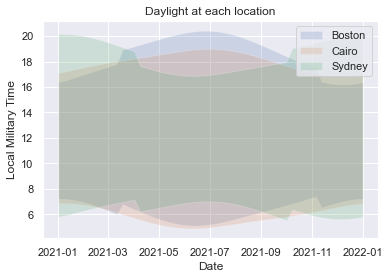

In [16]:
plot_daylight(df_annual_sun)